# Introduction

Welcome to this comprehensive guide on **binary classification** with the **Spaceship Titanic** dataset. The objective is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly.

*We will cover:*
* Exploratory Data Analysis
* Feature Engineering
* Data Cleaning
* Encoding, Scaling and Preprocessing
* Training Machine Learning Models
* Cross Validation and Ensembling Predictions

# Libraries

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
train= pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test= pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [3]:
print('train shape->',train.shape)
print('test shape->',test.shape)

train shape-> (8693, 14)
test shape-> (4277, 13)


# EDA

*Feature descriptions:*
> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> * **Destination** - The planet the passenger will be debarking to.
> * **Age** - The age of the passenger.
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> * **Name** - The first and last names of the passenger.
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

There are many features with object type we have convert it to int or float to train our models

In [6]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
train.isnull().sum()/len(train)*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [8]:
test.isnull().sum()/len(test)*100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

Almost every column have some missing values, it is very less in percentage but we have to deal with it.

<Axes: ylabel='count'>

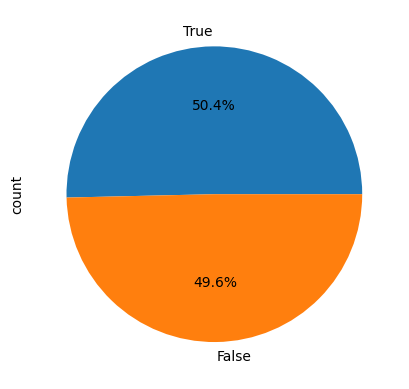

In [9]:
train['Transported'].value_counts().plot(kind='pie',autopct="%0.1f%%")

we have fairly balanced target column so we does not have to consider under or oversampling techinque

In [10]:
print('dupictes in train data->',train.duplicated().sum())
print('dupictes in test data->',test.duplicated().sum())

dupictes in train data-> 0
dupictes in test data-> 0


Text(0.5, 0, 'Age (years)')

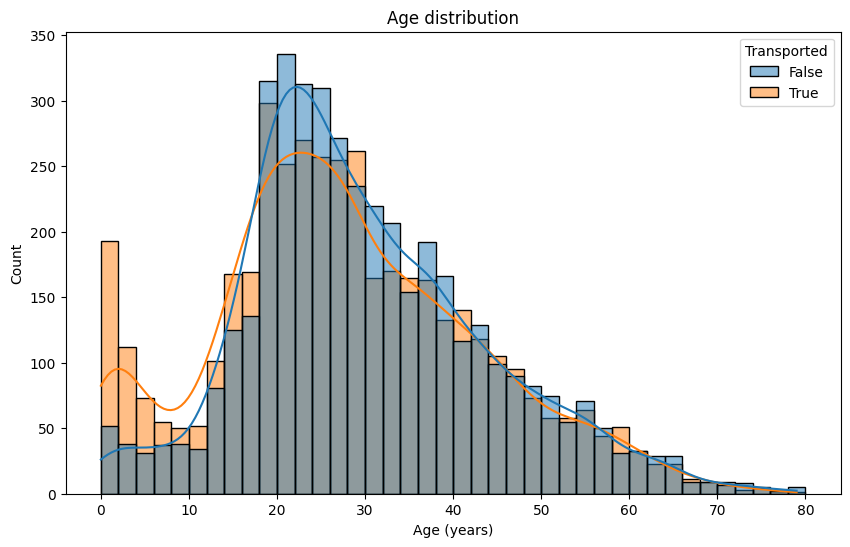

In [11]:
# Figure size
plt.figure(figsize=(10,6))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=2, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

*Notes:*
* 0-18 year olds were **more** likely to be transported than not.
* 18-26 year olds were **less** likely to be transported than not.
* Over 26 year olds were about **equally** likely to be transported than not.

*Insight:*
* Create a new feature that indicates whether the passanger is a child, adolescent or adult.

<Axes: ylabel='count'>

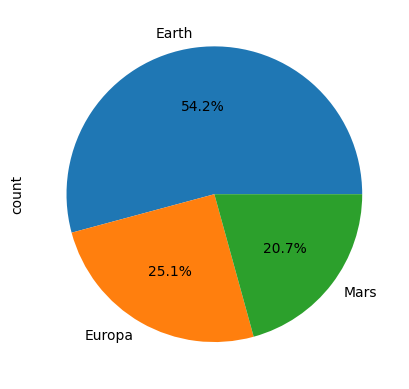

In [12]:
train['HomePlanet'].value_counts().plot(kind='pie',autopct="%0.1f%%")

<Axes: xlabel='HomePlanet', ylabel='count'>

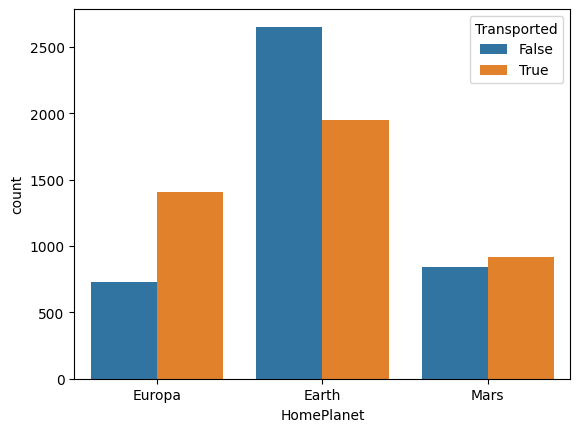

In [13]:
sns.countplot(data=train,x='HomePlanet',hue="Transported")

<Axes: ylabel='count'>

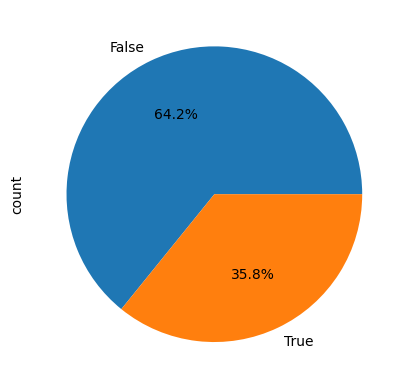

In [14]:
train['CryoSleep'].value_counts().plot(kind='pie',autopct="%0.1f%%")

In [15]:
train['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

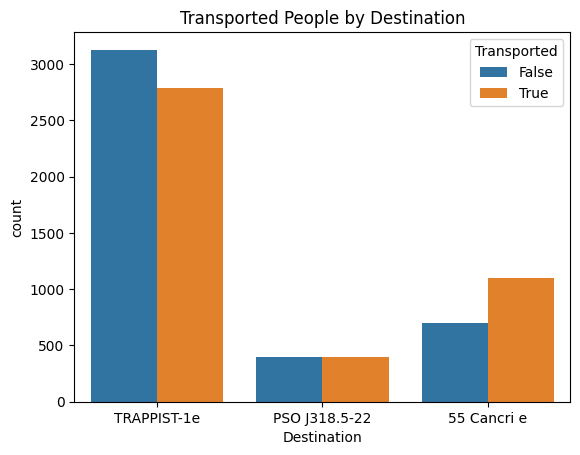

In [16]:
sns.countplot(data=train, x='Destination', hue='Transported')
plt.title('Transported People by Destination')
plt.show()


<Axes: ylabel='count'>

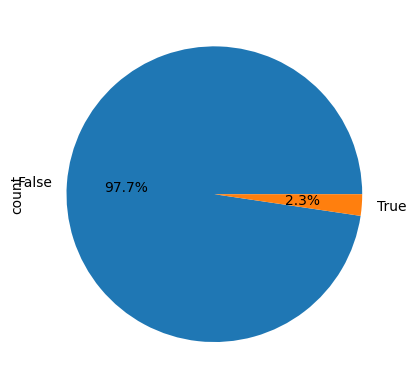

In [17]:
train['VIP'].value_counts().plot(kind='pie',autopct="%0.1f%%")

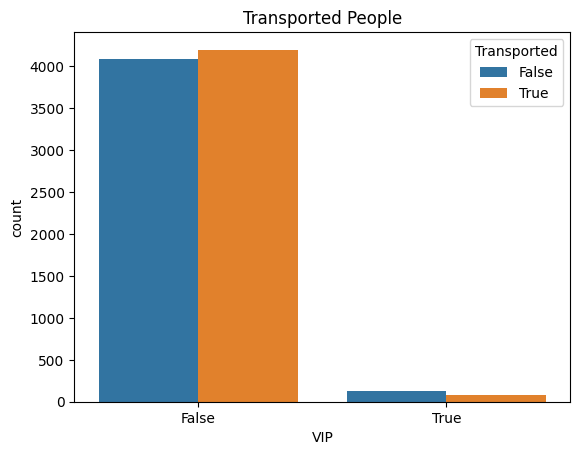

In [18]:
sns.countplot(data=train, x='VIP', hue='Transported')
plt.title('Transported People')
plt.show()


In [19]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Data Preprocessing

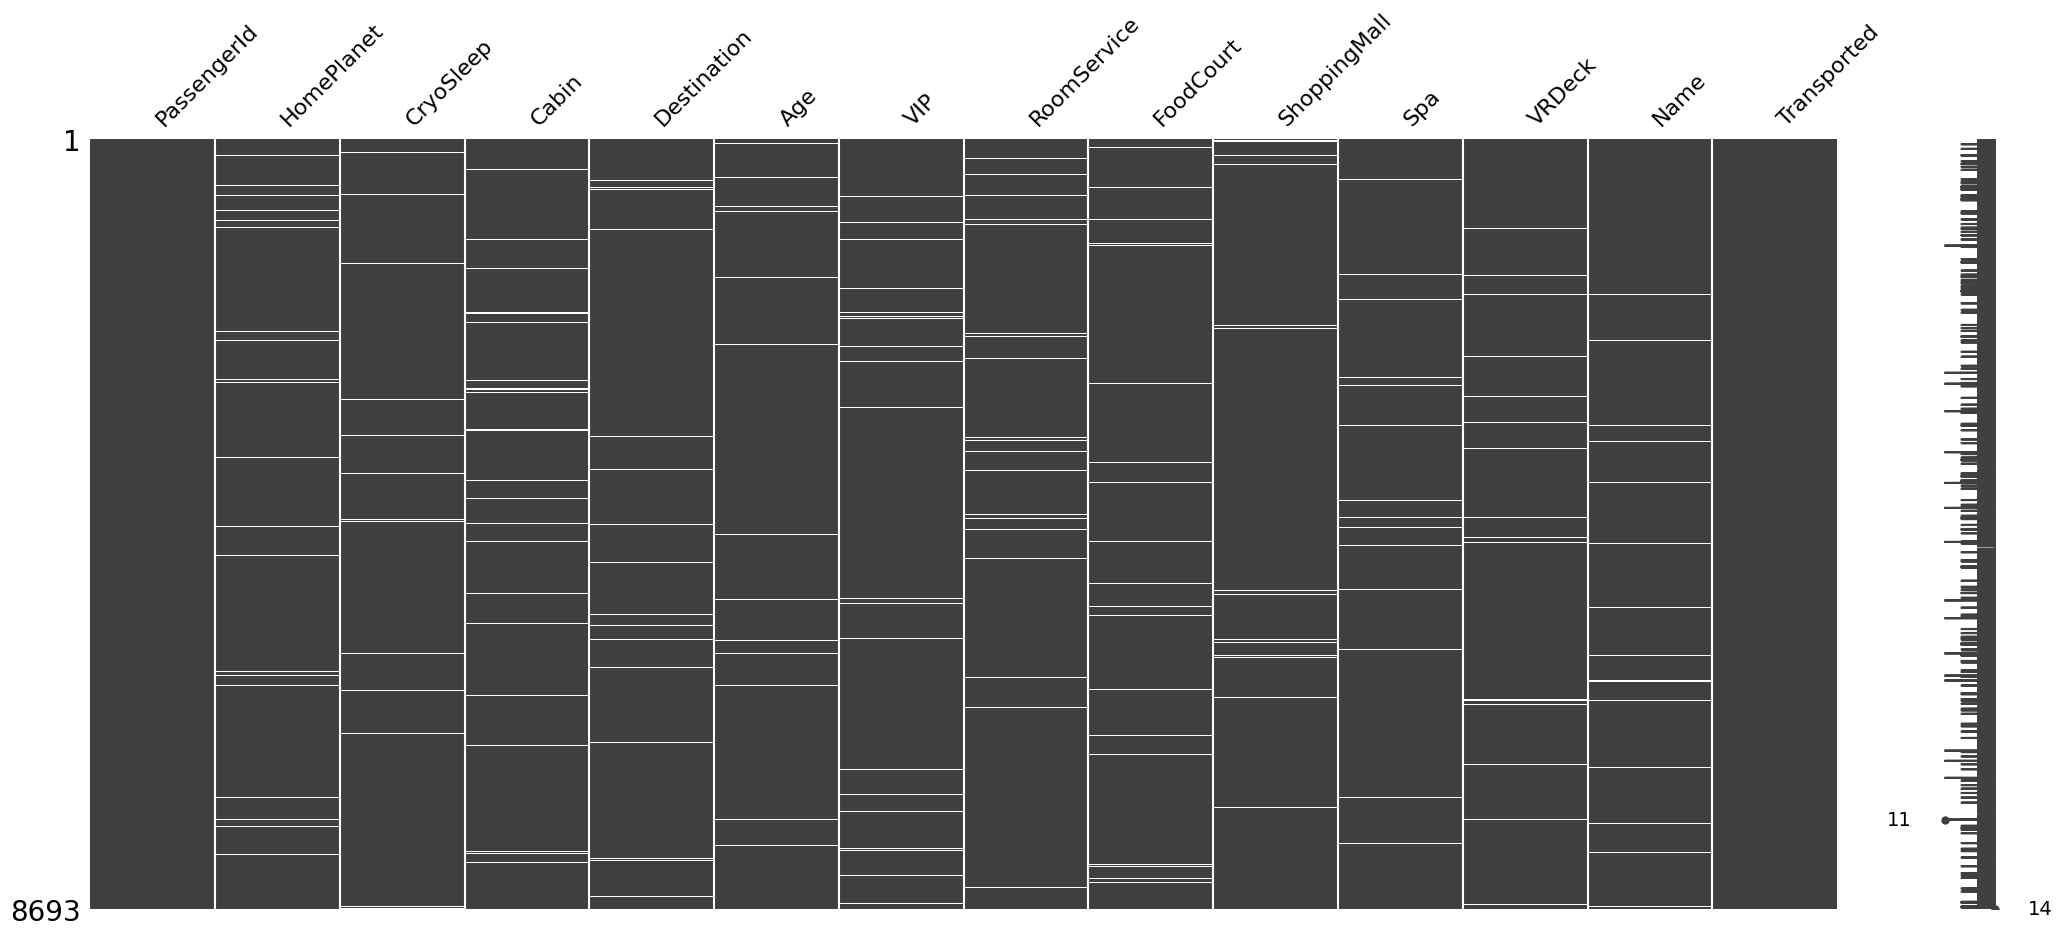

In [20]:
import missingno as msno

msno.matrix(train)
plt.show()


In [21]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8080,8638_01,Earth,True,G/1402/P,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,0.0,0.0,Therta Holliams,False
7816,8342_01,Europa,False,E/548/S,TRAPPIST-1e,48.0,False,0.0,NaN,0.0,408.0,293.0,Tach Sprender,True
3432,3702_01,Mars,True,E/220/P,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Tors Ramad,False
828,0883_01,Earth,False,G/127/P,TRAPPIST-1e,13.0,False,875.0,5.0,10.0,18.0,0.0,Elson Malliamsey,False
5847,6191_01,Europa,True,A/59/P,TRAPPIST-1e,51.0,False,0.0,0.0,0.0,0.0,0.0,Alraida Ametic,True


In [22]:

train['Cabin_number']= train['Cabin'].str.split('/').str[1]
train['Cabin_deck']= train['Cabin'].str.split('/').str[0]
train['Cabin_side']= train['Cabin'].str.split('/').str[2]


In [23]:

test['Cabin_number']= test['Cabin'].str.split('/').str[1]
test['Cabin_deck']= test['Cabin'].str.split('/').str[0]
test['Cabin_side']= test['Cabin'].str.split('/').str[2]

In [24]:
train['expenditure'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)


In [25]:
test['expenditure'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [26]:
train.drop(columns=['Cabin','Name','PassengerId'],axis=1,inplace=True)

In [27]:
test.drop(columns=['Cabin','Name','PassengerId'],axis=1,inplace=True)

In [28]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_number,Cabin_deck,Cabin_side,expenditure
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,B,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,F,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,A,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,A,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,S,1091.0


In [29]:
train['Cabin_number']=train['Cabin_number'].astype('float64')
test['Cabin_number']=test['Cabin_number'].astype('float64')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Cabin_number  8494 non-null   float64
 12  Cabin_deck    8494 non-null   object 
 13  Cabin_side    8494 non-null   object 
 14  expenditure   8693 non-null   float64
dtypes: bool(1), float64(8), object(6)
memory usage: 959.4+ KB


In [31]:
from sklearn.impute import KNNImputer

# Select only numerical columns
num_cols = train.select_dtypes(include=['float64']).columns

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=7)  # You can tune 'n_neighbors' for better results

# Apply KNN imputation
train[num_cols] = knn_imputer.fit_transform(train[num_cols])
test[num_cols] = knn_imputer.transform(test[num_cols])  # Use transform on test set


In [32]:
for col in test.select_dtypes(include='object'):
    test[col].fillna(test[col].mode()[0], inplace=True)

for col in train.select_dtypes(include='object'):
    train[col].fillna(train[col].mode()[0], inplace=True)

In [33]:
test.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Cabin_number    0
Cabin_deck      0
Cabin_side      0
expenditure     0
dtype: int64

In [34]:
train.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Cabin_number    0
Cabin_deck      0
Cabin_side      0
expenditure     0
dtype: int64

In [35]:
from sklearn.preprocessing import LabelEncoder

# Select categorical columns excluding 'Transported'
num_cols = train.select_dtypes(include=['object', 'bool']).columns
num_cols = num_cols.drop('Transported', errors='ignore')  # Exclude target safely

# Apply Label Encoding
for col in num_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])  # Fit & transform on train
    test[col] = le.transform(test[col])  # Transform test using the same encoder


In [36]:
X= train.drop('Transported',axis=1)
y= train['Transported']

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),
    }

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best params
print("Best parameters:", study.best_params)

# Train final model with best params
best_params = study.best_params
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")


[I 2025-02-24 10:40:36,445] A new study created in memory with name: no-name-e78757bf-b367-4d6a-ac80-895db0a5d08b
[I 2025-02-24 10:40:37,160] Trial 0 finished with value: 0.7987349051178838 and parameters: {'n_estimators': 1450, 'max_depth': 7, 'learning_rate': 0.06729883715196217, 'subsample': 0.9895078040358087, 'colsample_bytree': 0.5911877084159718, 'gamma': 2.8421737888363117, 'lambda': 4.174698687019044, 'alpha': 0.011002593004709323}. Best is trial 0 with value: 0.7987349051178838.
[I 2025-02-24 10:40:37,939] Trial 1 finished with value: 0.7987349051178838 and parameters: {'n_estimators': 1600, 'max_depth': 6, 'learning_rate': 0.04796877882911074, 'subsample': 0.8517146052442535, 'colsample_bytree': 0.8900773133538085, 'gamma': 4.652387967843347, 'lambda': 0.7863010066431355, 'alpha': 0.031033057068454745}. Best is trial 0 with value: 0.7987349051178838.
[I 2025-02-24 10:40:40,181] Trial 2 finished with value: 0.8050603795284647 and parameters: {'n_estimators': 1100, 'max_depth'

Best parameters: {'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.07196140771810211, 'subsample': 0.7096077750399835, 'colsample_bytree': 0.9425502013998639, 'gamma': 1.0304919652729219, 'lambda': 0.3906400349847431, 'alpha': 1.662166566195501}
Final Accuracy: 0.8091


In [39]:
xgb_pred = model.predict(test)
xgb_pred

array([1, 0, 1, ..., 1, 1, 1])

In [40]:

# Load sample submission
Submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

# Assign predictions
Submission['Transported'] = xgb_pred

Submission['Transported'] = Submission['Transported'].astype(bool)
Submission.to_csv('submission.csv', index=False)


# Check if the file exists
import os
print("Files in current directory:", os.listdir())

# Display the saved file
Submission.head()


Files in current directory: ['__notebook__.ipynb', 'submission.csv']


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
